In [37]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

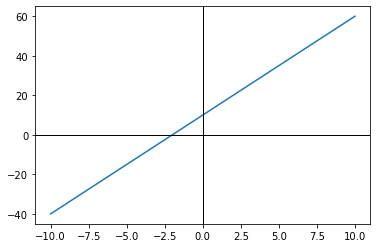

In [38]:
w, b = 5, 10
X = torch.linspace(-10, 10, 100)
Y = X*w + b

plt.plot(X, Y)
plt.axvline(0, linewidth=1, c='k')
plt.axhline(0, linewidth=1, c='k')
plt.show()

In [39]:
l = torch.linspace(-10, 20, 1001)
W, B = torch.meshgrid(l, l, indexing='ij')
B = B.flip(0)

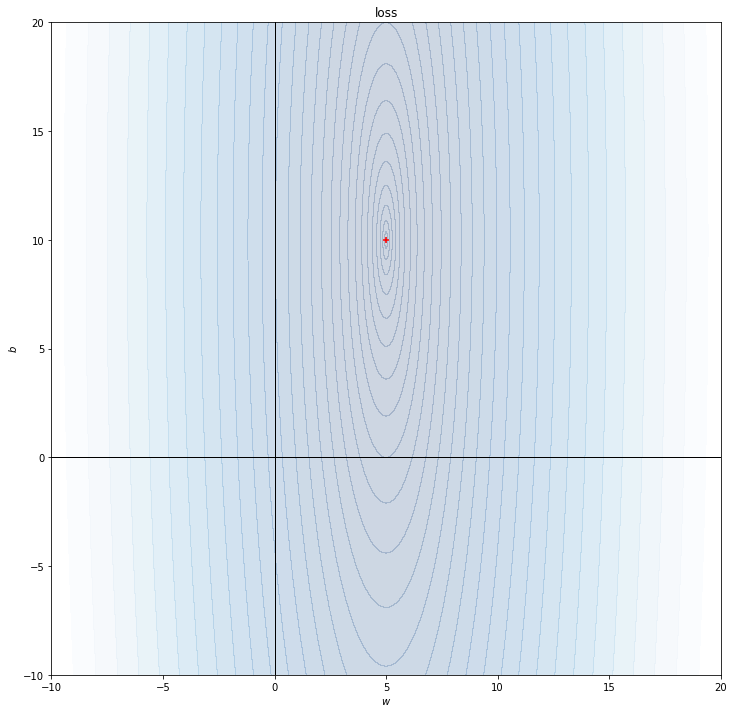

In [40]:
temp = 0
for x, y in zip(X, Y):
    temp += ((W*x+B) - y)**2

fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('loss')
ax.contourf(W, B, temp, levels=[i**4 for i in range(30)], alpha=.2, cmap='Blues_r')
ax.scatter(w, b, marker='+', c='r')
ax.axvline(0, linewidth=1, c='k')
ax.axhline(0, linewidth=1, c='k')
ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$b$')
plt.show()

In [41]:
class Neuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=True)
        nn.init.constant_(self.linear.weight, 0)
        nn.init.constant_(self.linear.bias, 0)
    
    @property
    def W(self):
        return self.linear.weight.item(), self.linear.bias.item()
        
    def forward(self, x):
        return self.linear(x)

model = Neuron()
print(f"{'weight':-^30}")
print(model.linear.weight)
print(f"{'bias':-^30}")
print(model.linear.bias)

------------weight------------
Parameter containing:
tensor([[0.]], requires_grad=True)
-------------bias-------------
Parameter containing:
tensor([0.], requires_grad=True)


In [42]:
class Points(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = Points(X, Y)

In [43]:
model.__init__()
model.train()

torch.manual_seed(42)

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=.1, weight_decay=0) # weight_decay == L2 penalty ratio
epoch = 200

history = []
for e in tqdm(range(epoch)):
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        y_hat = model(x.unsqueeze(1))
        loss = criterion(y_hat, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    history.append([e, i, loss.item(), *model.W])

df = pd.DataFrame(history, columns=['epoch', 'batch', 'loss', 'w', 'b'])
df

100%|██████████| 200/200 [00:00<00:00, 313.33it/s]


,epoch,batch,loss,w,b
0,0,9,87.887756,4.156923,4.625340
1,1,9,16.587109,4.784178,6.426741
2,2,9,6.098898,4.938661,7.568774
3,3,9,2.998999,4.978716,8.347009
4,4,9,1.338690,4.994615,8.887574
...,...,...,...,...,...
195,195,9,0.000000,5.000000,10.000000
196,196,9,0.000000,5.000000,10.000000
197,197,9,0.000000,5.000000,10.000000
198,198,9,0.000000,5.000000,10.000000


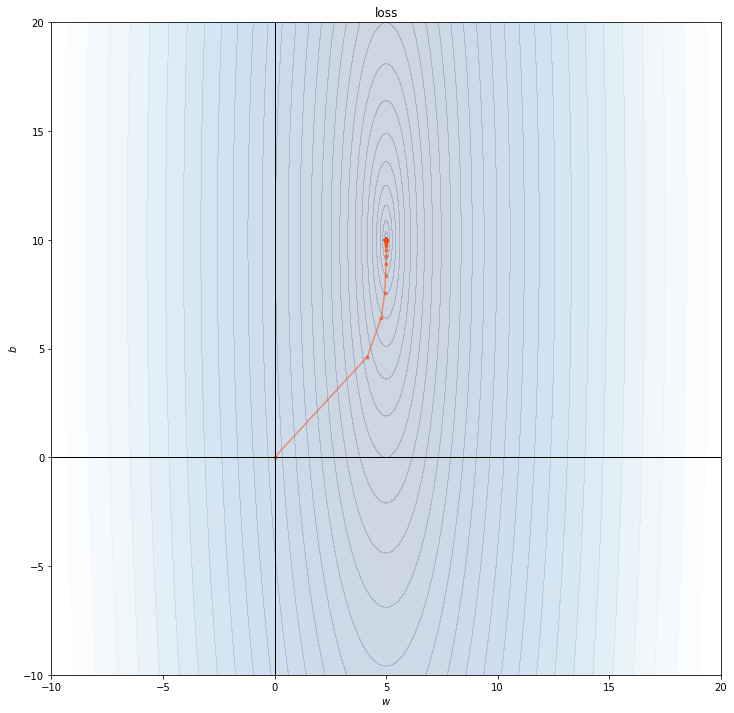

In [44]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('loss')
ax.contourf(W, B, temp, levels=[i**4 for i in range(30)], alpha=.2, cmap='Blues_r')
ax.plot([0, *df['w']], [0, *df['b']], '.-', c='orangered', alpha=.5)
ax.scatter(w, b, marker='+', c='r')
ax.axvline(0, linewidth=1, c='k')
ax.axhline(0, linewidth=1, c='k')
ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$b$')
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)
plt.show()

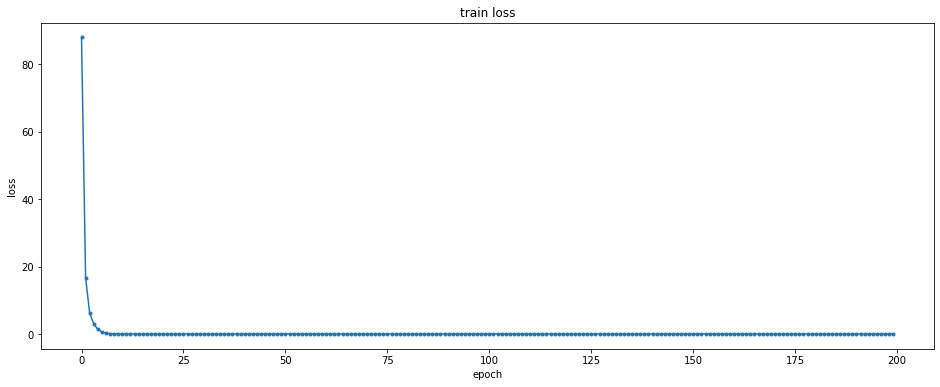

In [45]:
plt.figure(figsize=(16, 6))
plt.plot(df['loss'], '.-')
plt.title('train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()